In [1]:
import numpy as np
import torch
from torch import optim
import os
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import get_data_loader
from networks.cnn import CNN, CNN_pool
import matplotlib.pyplot as plt
import pyreadr

# Results from all image fit PL

In [2]:
exp = "exp_2"
path = f'../data/{exp}/data/'
brown_params = np.unique(pyreadr.read_r(path+"brown_test_params.RData")["test_params"].to_numpy(), axis = 0)
schlather_params = np.unique(pyreadr.read_r(path+"schlather_test_params.RData")["test_params"].to_numpy(), axis = 0)

In [3]:
path = f'../data/{exp}/results/'
brown_res = pyreadr.read_r(path+"brown_fit_all_images.RData")["res"].to_numpy()
schlather_res = pyreadr.read_r(path+"schlather_fit_all_images.RData")["res"].to_numpy()[:,1:]

In [4]:
#Brown results
res = brown_params-brown_res
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(rmse)
print(mae)

[0.52283179 0.39617142]
[0.40970033 0.32178452]


In [5]:
#Schlather results
res = schlather_params-schlather_res
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(rmse)
print(mae)

[3.84299661 0.47828069]
[2.34036376 0.4088549 ]


In [71]:
schlather_res

array([[ 0.01564167,  0.1286946 ],
       [ 2.51313518,  0.35956051],
       [ 2.35018921,  1.06743012],
       [ 2.40043585,  0.75601164],
       [10.52898708,  0.66090683],
       [ 1.67693789,  0.49981864],
       [ 3.25224792,  1.99999947],
       [ 2.82389284,  0.88980415],
       [10.52941978,  0.6608482 ],
       [ 1.67264791,  0.87401773],
       [ 2.1346135 ,  1.13448073],
       [ 2.43745282,  1.46354442],
       [10.52941978,  0.6608482 ],
       [ 1.53197703,  1.37518207],
       [ 2.78198381,  0.67753704],
       [ 2.29262885,  1.9999997 ]])

# Results CNN Brown

In [53]:
# Dataloader
exp = "exp_2"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, dataset = get_data_loader(data_path = path, model = model, batch_size=800, var = "test")

In [54]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/exp_2/checkpoints/cnn_pool_{model}.pt"))
net.eval()

CNN_pool(
  (conv_input): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=2304, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=2, bias=True)
  (output_1): Linear(in_features=256, out_features=1, bias=True)
  (output_2): Linear(in_features=256, out_features=1, bias=True)
)

In [55]:
for sample in dataloader:
    img, param = sample
    break 
pred = net(img).detach().numpy()
param = param.detach().numpy()

# Calculate metrics

In [56]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    result[:,0] = np.exp(params[:,0])
    result[:,1] = (2*np.exp(params[:,1]))/(1+np.exp(params[:,1]))
    return result    

In [57]:
def retransform2(params):
    result = np.zeros(shape = params.shape)
    #result[:,0] = params[:,0]*(3-0.1)+0.1
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [58]:
pred_tf = retransform2(pred)
param_tf = np.round(retransform2(param),3)

In [59]:
param_tf

array([[0.5 , 0.8 ],
       [0.5 , 0.8 ],
       [0.5 , 0.8 ],
       ...,
       [1.5 , 1.55],
       [1.5 , 1.55],
       [1.5 , 1.55]])

In [60]:
rmse = np.sqrt(np.mean((np.power(pred_tf-param_tf,2)), axis = 0))
mae = np.mean(np.abs(pred_tf-param_tf), axis = 0)
bias = np.mean(pred_tf-param_tf, axis = 0)
print(f"RMSE: {np.round(rmse,2)}")
print(f"MAE: {np.round(mae,2)}")
print(f"Bias: {np.round(bias,2)}")

RMSE: [0.15 0.14]
MAE: [0.1  0.11]
Bias: [0.01 0.01]


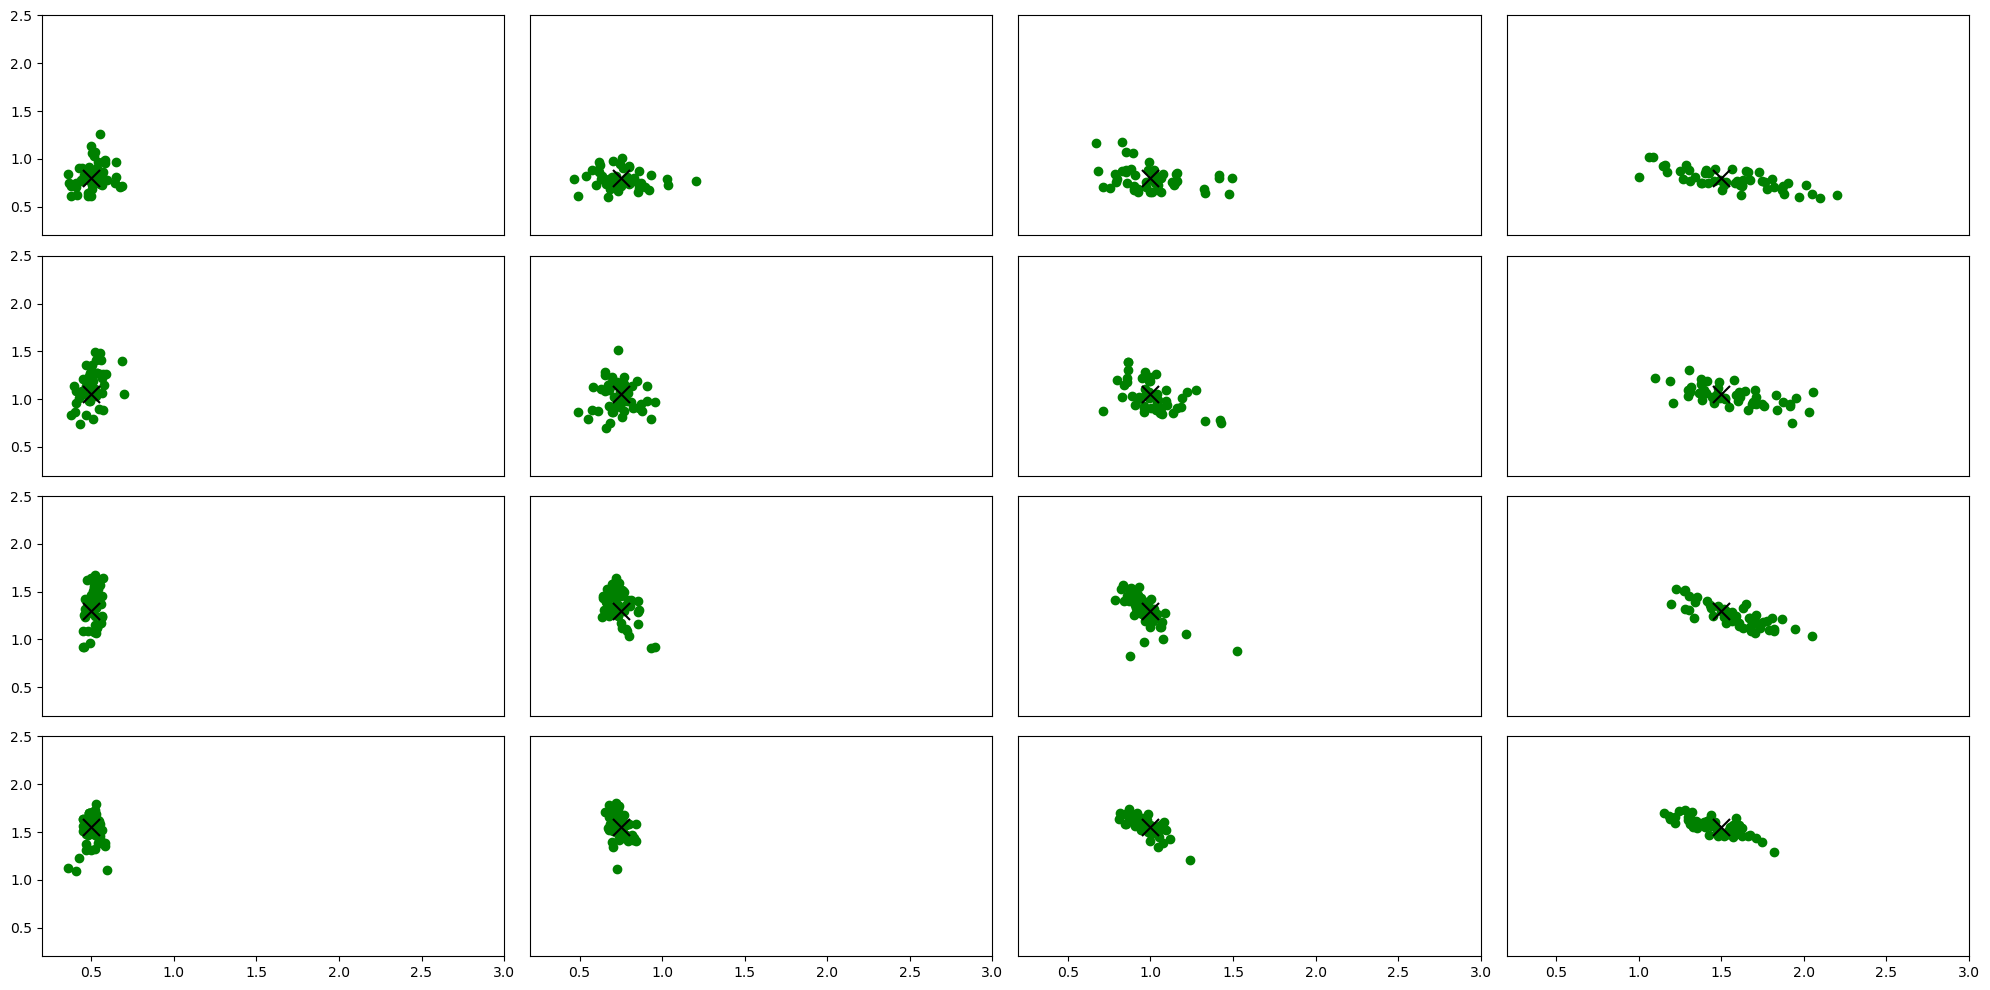

In [61]:
n_comb = 16
fig, axs = plt.subplots(4,4,figsize = (20,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*50):((i+1)*50),0], y = pred_tf[(i*50):((i+1)*50),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*50),0], y = param_tf[5+(i*50),1], color = "black", marker = "x", s = 150)
    axs[i].set_xlim([0.2,3])
    axs[i].set_ylim([0.2,2.5])
    
    if i < 12:
        axs[i].get_xaxis().set_visible(False)
    if (i%4) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

# Results CNN Schlather

In [62]:
# Dataloader
exp = "exp_2"
path = f"../data/{exp}/data/"
model = "schlather"
dataloader, dataset = get_data_loader(data_path = path, model = model, batch_size=800, var = "test")

In [63]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/exp_2/checkpoints/cnn_pool_{model}.pt"))
net.eval()

CNN_pool(
  (conv_input): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=2304, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=2, bias=True)
  (output_1): Linear(in_features=256, out_features=1, bias=True)
  (output_2): Linear(in_features=256, out_features=1, bias=True)
)

In [64]:
for sample in dataloader:
    img, param = sample
    break 
pred = net(img).detach().numpy()
param = param.detach().numpy()

# Calculate metrics

In [65]:
pred_tf = retransform2(pred)
param_tf = np.round(retransform2(param),3)

In [66]:
rmse = np.sqrt(np.mean((np.power(pred_tf-param_tf,2)), axis = 0))
mae = np.mean(np.abs(pred_tf-param_tf), axis = 0)
bias = np.mean(pred_tf-param_tf, axis = 0)
print(f"RMSE: {np.round(rmse,2)}")
print(f"MAE: {np.round(mae,2)}")
print(f"Bias: {np.round(bias,2)}")

RMSE: [0.36 0.2 ]
MAE: [0.27 0.15]
Bias: [-0.05 -0.03]


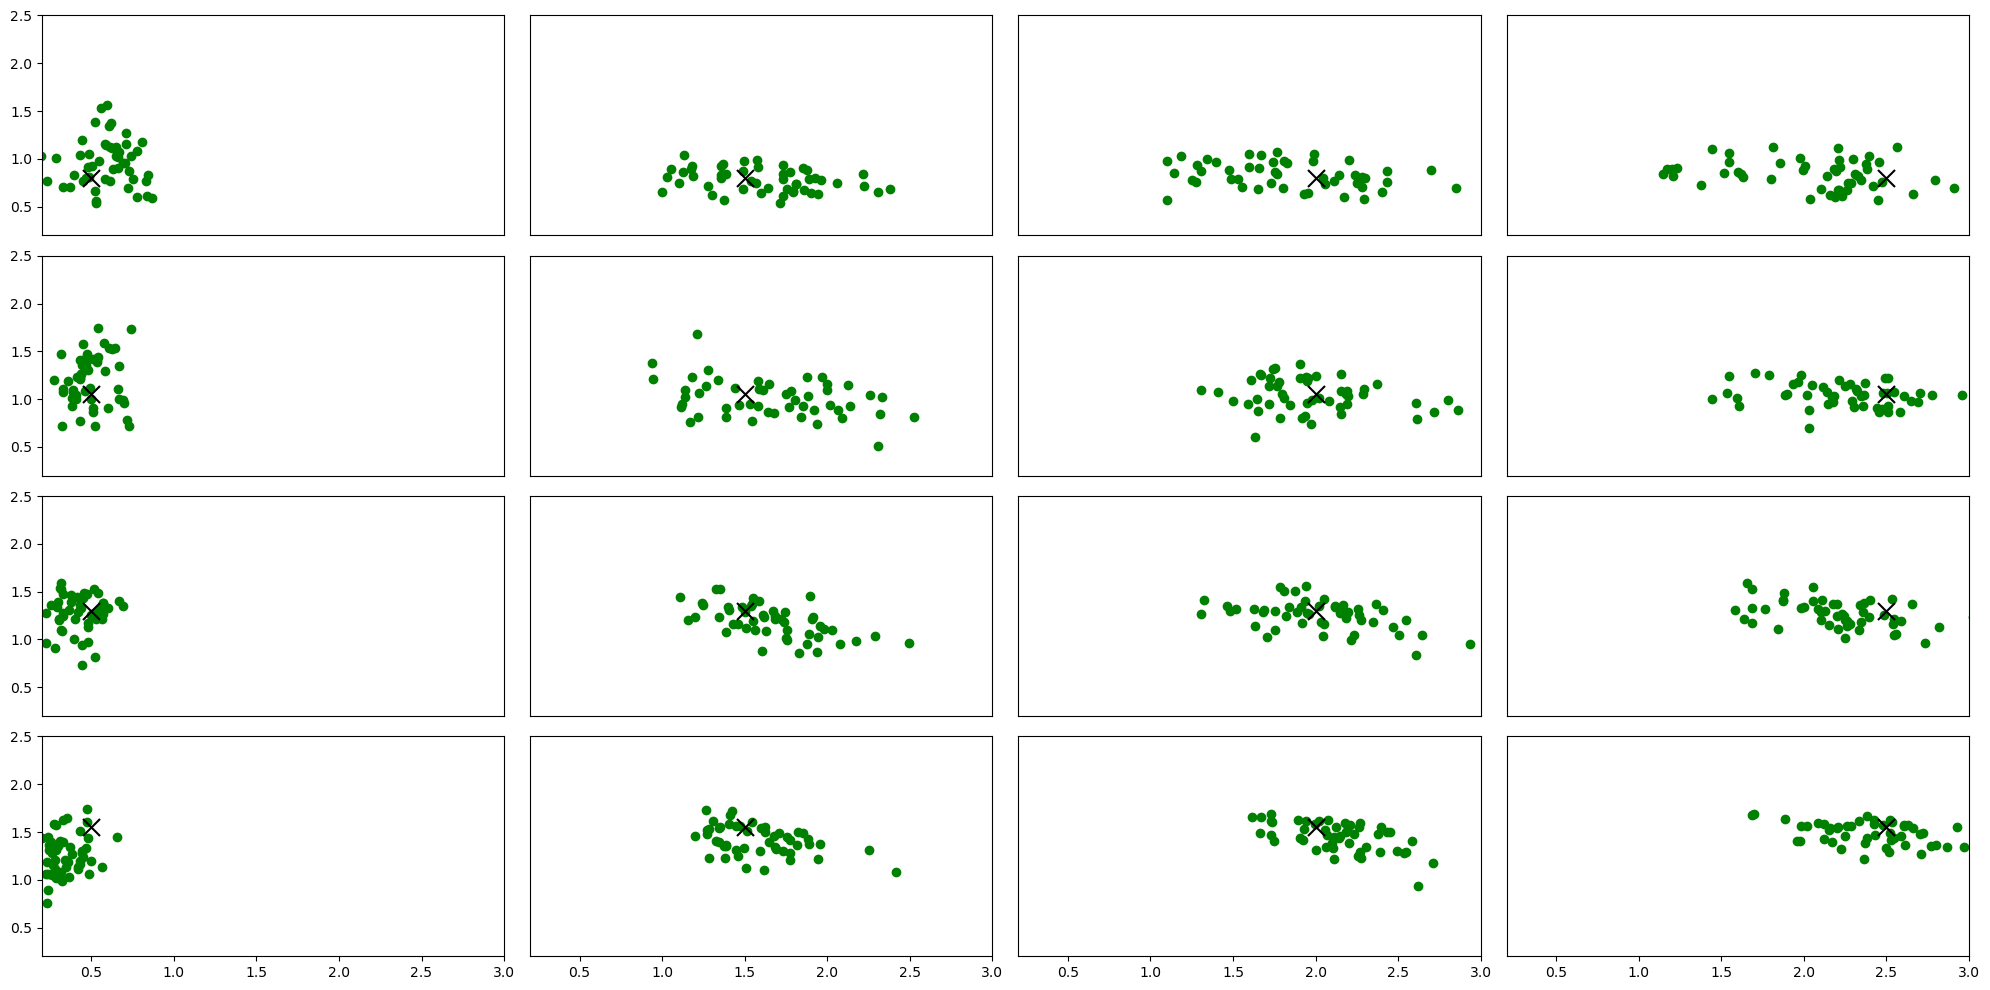

In [67]:
n_comb = 16
fig, axs = plt.subplots(4,4,figsize = (20,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*50):((i+1)*50),0], y = pred_tf[(i*50):((i+1)*50),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*50),0], y = param_tf[5+(i*50),1], color = "black", marker = "x", s = 150)
    axs[i].set_xlim([0.2,3])
    axs[i].set_ylim([0.2,2.5])
    
    if i < 12:
        axs[i].get_xaxis().set_visible(False)
    if (i%4) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

# Results with Likelihood

In [10]:
ml_path = f'../data/{exp}/results/'
ml_data = pyreadr.read_r(ml_path+model+"_mle2.RData")["results"].to_numpy()

In [11]:
rmse = np.sqrt(np.mean((np.power(ml_data-param_tf,2)), axis = 0))
mae = np.mean(np.abs(ml_data-param_tf), axis = 0)
bias = np.mean(ml_data-param_tf, axis = 0)
print(f"RMSE: {np.round(rmse,2)}")
print(f"MAE: {np.round(mae,2)}")
print(f"Bias: {np.round(bias,2)}")

RMSE: [0.53 0.2 ]
MAE: [0.43 0.16]
Bias: [0.42 0.01]


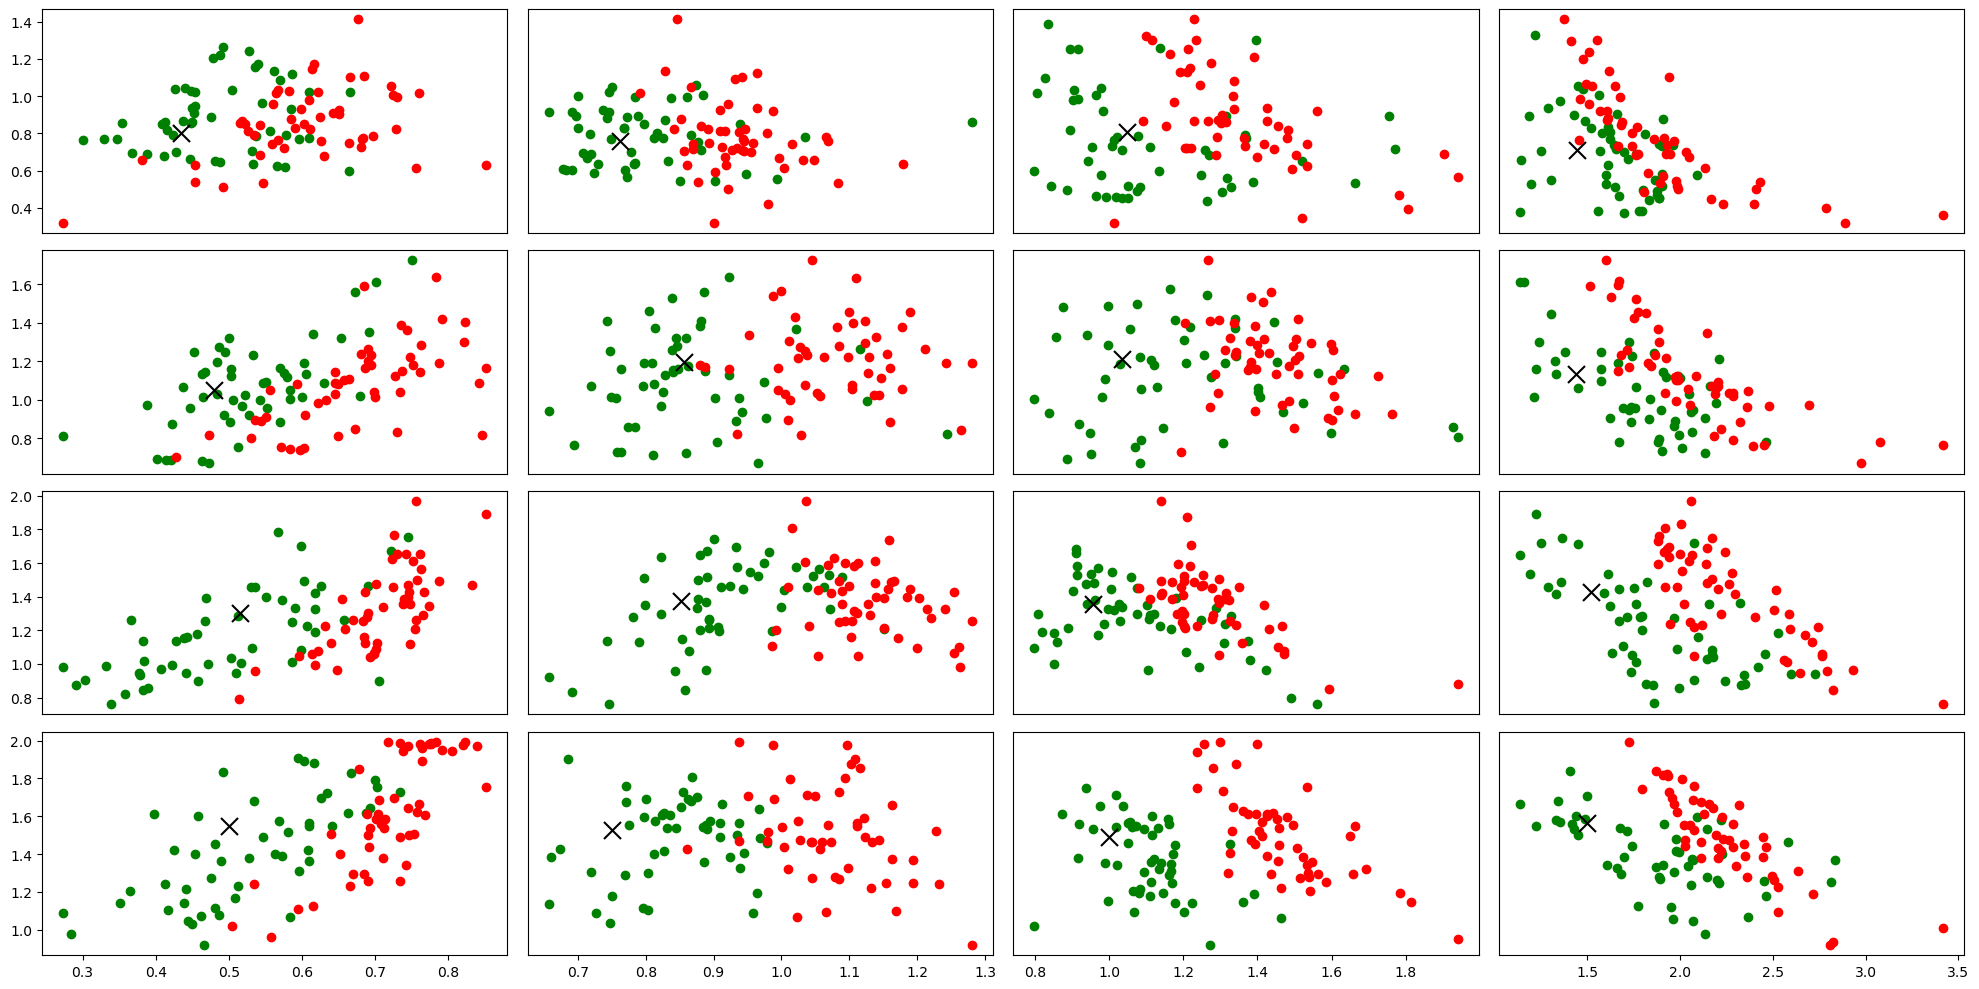

In [12]:
n_comb = 16
fig, axs = plt.subplots(4,4,figsize = (20,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*50):((i+1)*50),0], y = pred_tf[(i*50):((i+1)*50),1], color = "green")
    axs[i].scatter(x = ml_data[(i*50):((i+1)*50),0], y = ml_data[(i*50):((i+1)*50),1], color = "red")
    axs[i].scatter(x = param_tf[5+(i*50),0], y = param_tf[5+(i*50),1], color = "black", marker = "x", s = 150)
    if i < 12:
        axs[i].get_xaxis().set_visible(False)
    if (i%4) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()
plt.savefig(plot_path+"metrics_scatter_mle.png", dpi = 300, bbox_inches = "tight")